## Insurance price prediction

#### import libraries:

In [79]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#### load dataset:

In [80]:
df = pd.read_csv('d:\Dokumente\github code\insurance-price-prediction\insurance.csv')

#### data preparation:

In [81]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [82]:
# display NAs
print(df.isna().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [83]:
# verify data types of variables
print(df.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


age (int64): numerical variable

sex (object): categorical variable

bmi (float64): continuous variable

children (int64): discrete numerical variable (number of children)

smoker (object): categorical variable (e.g., "yes" or "no")

region (object): categorical variable

charges (float64): continuous numerical variable

In [84]:
# encode categorical variables
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})
df = pd.get_dummies(df, columns=['region'], prefix='region', dtype=int)

In [85]:
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,16884.92400,0,0,0,1
1,18,0,33.770,1,0,1725.55230,0,0,1,0
2,28,0,33.000,3,0,4449.46200,0,0,1,0
3,33,0,22.705,0,0,21984.47061,0,1,0,0
4,32,0,28.880,0,0,3866.85520,0,1,0,0


In [86]:
# standardize features, as they have different scales
# Initialize the Scaler
scaler = StandardScaler()
cols_to_scale = ['age', 'bmi', 'children']
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


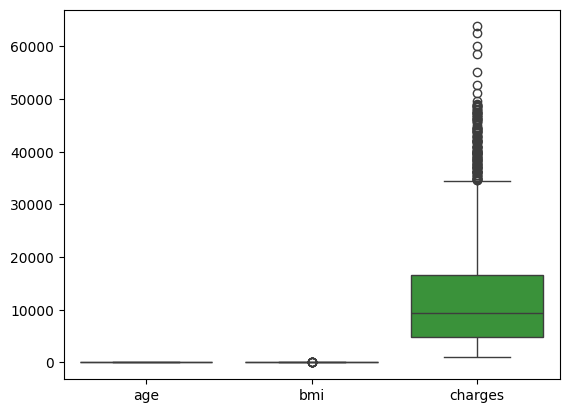

In [87]:
# check for outliers
sns.boxplot(data=df[['age', 'bmi', 'charges']])
plt.show()

To handle the outliers, I used the IQR method, meaning that I used the interquartile range (difference between the 25th percentile (Q1) and the 75th percentile (Q3)).

In [88]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for 'charges'
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df = df[(df['charges'] >= lower_bound) & (df['charges'] <= upper_bound)]

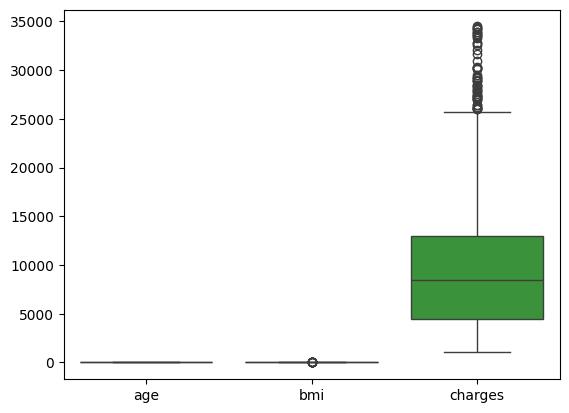

In [89]:
# check for outliers
sns.boxplot(data=df[['age', 'bmi', 'charges']])
plt.show()

#### descriptive statistics:

In [90]:
# descriptive statistics for numerical variables
df_numerical = df.drop(['sex', 'children','smoker','region_northeast','region_northwest','region_southeast','region_southwest'], axis = 1)
df_numerical.describe()

,age,bmi,charges
count,1199.000000,1199.000000,1199.000000
mean,-0.015453,-0.093210,9927.753402
std,1.001661,0.985998,7241.158309
min,-1.509965,-2.412011,1121.873900
25%,-0.940356,-0.797813,4408.695900
50%,-0.014740,-0.152298,8410.046850
75%,0.839674,0.517823,12953.594600
max,1.765289,3.685522,34472.841000


In [91]:
# frequency counts for categorical variables
print(df['sex'].value_counts())
print(df['smoker'].value_counts())
print(df['region_northeast'].value_counts())
print(df['region_northwest'].value_counts())
print(df['region_southeast'].value_counts())
print(df['region_southwest'].value_counts())

sex
1    612
0    587
Name: count, dtype: int64
smoker
0    1061
1     138
Name: count, dtype: int64
region_northeast
0    903
1    296
Name: count, dtype: int64
region_northwest
0    894
1    305
Name: count, dtype: int64
region_southeast
0    892
1    307
Name: count, dtype: int64
region_southwest
0    908
1    291
Name: count, dtype: int64


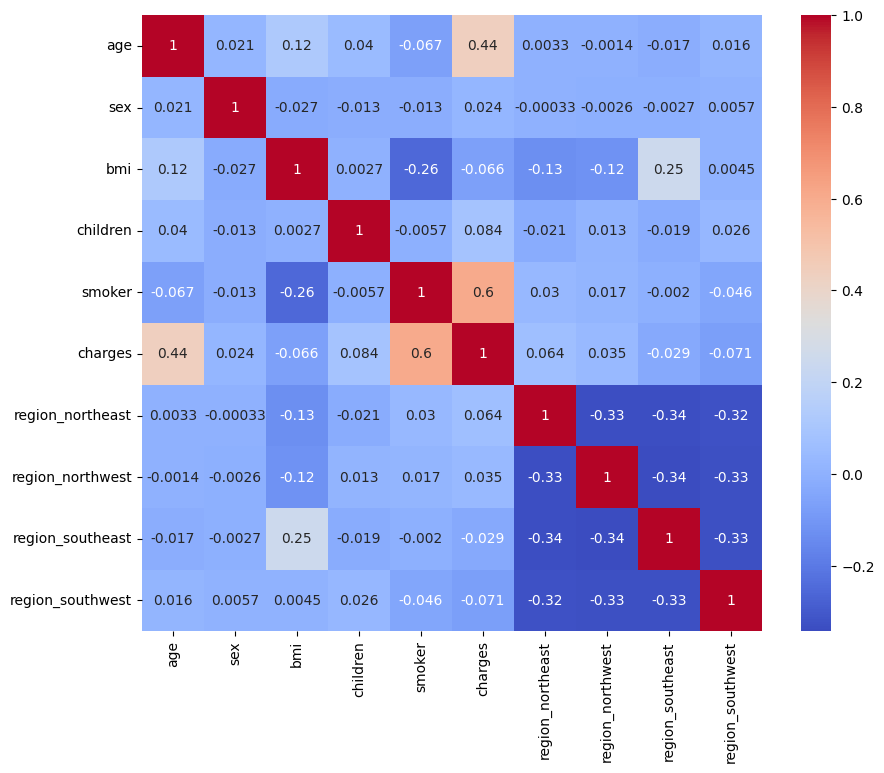

In [92]:
# correlation matrix
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()



The correlation between the features is low on the off diagonal, which is good and high on the diagonal. The main exception is given for the different regions. This is not problemtic as the correlation is not bigger than 0.34 and as region was presented as one feature at the beginning. 

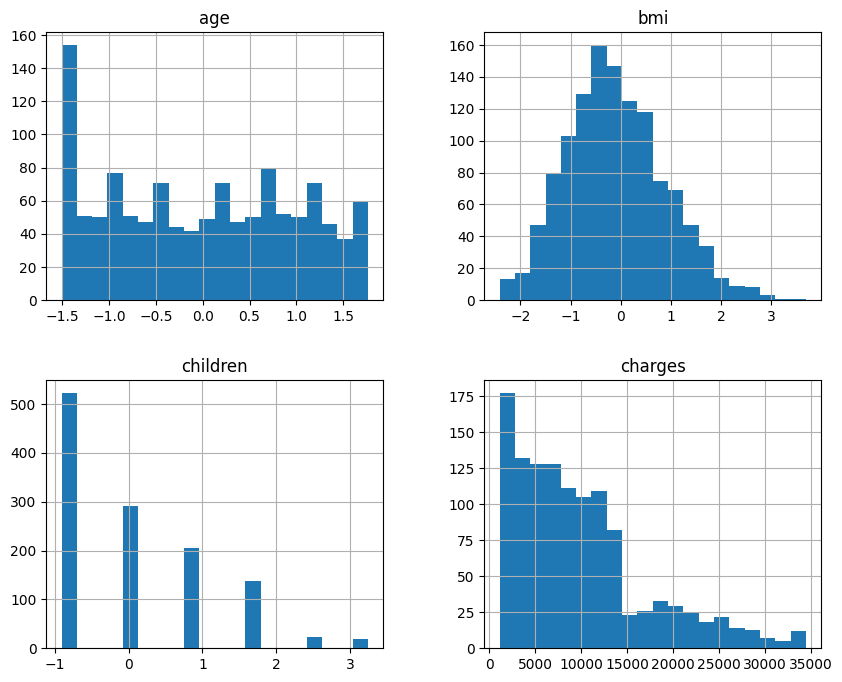

In [93]:
# distribution of numerical variables
df[['age', 'bmi', 'children', 'charges']].hist(bins=20, figsize=(10, 8))
plt.show()

The target variable is not normally distributed, it is skewed to the right, which is problematic when using a linear regression model. This will be considered in the next model, after the linear regression model. Or I will use a log-transform for the target variable charges (not decided yet).

In [94]:
# cross-tabulation for categorical variables
pd.crosstab(df['smoker'], df['sex'])

sex,0,1
smoker,,
0,517,544
1,70,68


In [95]:
# Mean charges
def mean_charges(col):
    mean_charges = df.groupby(col)['charges'].mean()
    return mean_charges

print('mean_charges:', mean_charges('smoker'))
print('mean_charges:', mean_charges('sex'))
print('mean_charges:', mean_charges('region_northwest'))
print('mean_charges:', mean_charges('region_southwest'))
print('mean_charges:', mean_charges('region_southeast'))


mean_charges: smoker
0     8355.712011
1    22014.245543
Name: charges, dtype: float64
mean_charges: sex
0     9747.728372
1    10100.424469
Name: charges, dtype: float64
mean_charges: region_northwest
0     9779.060858
1    10363.593187
Name: charges, dtype: float64
mean_charges: region_southwest
0    10218.209265
1     9021.451259
Name: charges, dtype: float64
mean_charges: region_southeast
0    10049.408162
1     9574.280940
Name: charges, dtype: float64


As the outliers of the data were removed, the mean_charges are slightly impacted by that.

### linear regression model:

#### test- and training split:

In [96]:
X = df.drop('charges', axis = 1)
y = df['charges']

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (959, 9)
X_test shape: (240, 9)
y_train shape: (959,)
y_test shape: (240,)


#### modeling using Ordinary Least Squares:

In [97]:
def OLS_regression(X_test, X_train, y_train):
    # append columns of ones to X_train and X_test
    X_train_offset= np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
    X_test_offset = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
    # create the left side of the function to calculate the weights
    left = np.matmul(X_train_offset.transpose(), X_train_offset)
    # create the right side of the function to calculate the weights
    right = np.matmul(X_train_offset.transpose(), y_train)
    # take the pseudo inverse of the left side and multiply it with the right side to calculate the weights
    weights = np.matmul(np.linalg.pinv(left), right)
    # calculate the test set prediction
    y_pred = np.matmul(X_test_offset, weights)
    return weights, y_pred



In [98]:
# call the OLS regression function
weights, y_pred = OLS_regression(X_test, X_train, y_train)

In [99]:
# evaluate the model's performance using R-squared
def r_squared(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true))**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    return 1 - (ss_residual / ss_total)

# evaluate the model's performance using MSE
def mean_squared_error(y_true, y_pred):
    # Convert inputs to numpy arrays (if they are not already)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # calculate the squared differences and then the mean
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [100]:
def plot_regression_results(y_test, y_pred, weights):
    # calculate and print the R-squared value
    r2 = r_squared(y_test, y_pred)
    print("R-squared:", r2)
    # calculate and print the MSE value
    mse = mean_squared_error(y_test, y_pred)
    print("mean squared error:", mse)
    fig,ax = plt.subplots(1,3,figsize=(9,3))
    # predicted vs true
    ax[0].scatter(y_test,y_pred)
    ax[0].set_title('True vs. Predicted')
    ax[0].set_xlabel('True' % (y_test))
    ax[0].set_ylabel('Predicted' % (y_pred))

    # residuals
    error = np.squeeze(np.array(y_test)) - np.squeeze(np.array(y_pred))
    ax[1].hist(np.array(error),bins=30)
    ax[1].set_title('Raw residuals')
    ax[1].set_xlabel('(true-predicted)')

    # weight histogram
    ax[2].hist(weights,bins=30)
    ax[2].set_title('weight histogram')

    plt.tight_layout()

R-squared: 0.5568176371144351
mean squared error: 27645846.66499934


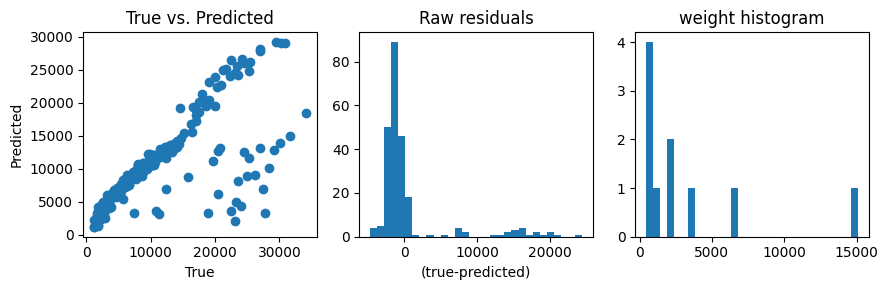

In [101]:
plot_regression_results(y_test, y_pred, weights)

The R-squared of 0.56 shows, that the model explains 56 % of the variance, which is moderate and indicates room for improvement. 

